### Load libraries

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import string
import unicodedata
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Device selection

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 

cuda:0


### Prepare dataset

In [0]:
all_chars = string.ascii_letters + " .,;'-\n"
num_chars = len(all_chars)

# From https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def unicode_to_ascii(string):
  return ''.join([
      char for char in unicodedata.normalize('NFD', string) 
      if char in all_chars])

file            = unicode_to_ascii(open('/content/gdrive/My Drive/Data/input.txt', 
                                        encoding='utf-8').read())
file_len        = len(file)
print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(num_chars))

Length of file: 1100413
All possible characters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-

Number of all possible characters: 59


In [0]:
# Get a sample sequence of the Shakespeare dataset.
def sample_sequence():
    sequence_length = 128
    index_start = np.random.randint(file_len - sequence_length - 1)
    index_end = index_start + sequence_length + 1
    input_sequence = file[index_start:index_end]
    return input_sequence

# Convert the sequence to one-hot tensor.
def sequence_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, num_chars) 
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to target tensor.
def sequence_to_target(seq):
    tensor = torch.zeros(len(seq), 1)
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = sample_sequence()
    input  = sequence_to_onehot(seq[:-1])      
    target = sequence_to_target(seq[1:]).long() 
    return input, target

# From https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# Time elapsed for each epoch and its respective iterations
def timeSince(since):
    now = time.time()
    s = now - since
    m = (s//60)
    s -= m*60
    return '{} minute(s) {} second(s)'.format(int(m), int(s))
 

### LSTM Network Definition

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size  = input_size  
        self.hidden_size = hidden_size       
        self.output_size = output_size 
        self.loss_history = []
        self.print_iterations = 500
        
        self.LSTM = nn.LSTM(self.input_size, self.hidden_size, num_layers = 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
         
    def forward(self, input, hidden):
        output, hidden = self.LSTM(input.view(1, 1, -1), hidden)
        output = self.dropout(output)
        output = self.fc(output.view(1, -1))
        output= F.log_softmax(output, dim = -1)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1,self.hidden_size).to(device), 
                torch.zeros(1, 1,self.hidden_size).to(device))
      
    def train(self, optimizer, criterion, epochs, iterations):
        initial_time = time.time()
        for i in range(epochs):
            total_loss = 0
            for j in range(iterations):
              
                input, target = get_input_and_target()
                input  = input.to(device)
                target = target.to(device)
                
                sequence_length = input.shape[0]
                hidden = self.init_hidden()
                self.zero_grad()
                loss = 0
              
                for k in range(sequence_length):    
                    output, hidden = self(input[k], hidden)
                    loss += criterion(output, target[k])

                loss.backward()             
                optimizer.step()
              
                loss_per_iter = loss / sequence_length   
                total_loss += loss_per_iter.item()                                
   
                if j % self.print_iterations == self.print_iterations - 1:
                    print('Epoch: {} | Iteration: {}/{}'
                    .format(i+1, j, iterations))
                    print('Loss: {}\nTime: {}\n'
                          .format(total_loss/self.print_iterations, timeSince(initial_time)))
        
                    self.loss_history.append(total_loss/self.print_iterations)
                    total_loss = 0  
    
    def generate(self, initial_sequence='W', predicted_length=100):
        hidden        = self.init_hidden()
        initial_input = sequence_to_onehot(initial_sequence).to(device)
        predicted_sequence = initial_sequence

        for i in range(len(initial_sequence) - 1):
            output, hidden = net(initial_input[i], hidden)
        
        input = initial_input[-1]
    
        for i in range(predicted_length):
            output, hidden = self(input, hidden)    
            predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
            predicted_char  = all_chars[predicted_index]
            predicted_sequence  += predicted_char
            input = sequence_to_onehot(predicted_char)[0].to(device)

        return predicted_sequence

### Training Procedure

In [0]:
sq = LSTM(num_chars, 512, num_chars)
model = sq.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

epochs = 60
iterations = 1000
model.train(optimizer, criterion, epochs, iterations)

Epoch: 1 | Iteration: 499/1000
Loss: 2.5982744443416594
Time: 1 minute(s) 23 second(s)

Epoch: 1 | Iteration: 999/1000
Loss: 2.1254737606048586
Time: 2 minute(s) 46 second(s)

Epoch: 2 | Iteration: 499/1000
Loss: 1.9694573953151704
Time: 4 minute(s) 8 second(s)

Epoch: 2 | Iteration: 999/1000
Loss: 1.8854235243797302
Time: 5 minute(s) 29 second(s)

Epoch: 3 | Iteration: 499/1000
Loss: 1.8137236771583558
Time: 6 minute(s) 51 second(s)

Epoch: 3 | Iteration: 999/1000
Loss: 1.7612533905506134
Time: 8 minute(s) 12 second(s)

Epoch: 4 | Iteration: 499/1000
Loss: 1.730601868391037
Time: 9 minute(s) 35 second(s)

Epoch: 4 | Iteration: 999/1000
Loss: 1.7209507598876954
Time: 10 minute(s) 58 second(s)

Epoch: 5 | Iteration: 499/1000
Loss: 1.68990131855011
Time: 12 minute(s) 21 second(s)

Epoch: 5 | Iteration: 999/1000
Loss: 1.6579795668125152
Time: 13 minute(s) 44 second(s)

Epoch: 6 | Iteration: 499/1000
Loss: 1.643917755126953
Time: 15 minute(s) 6 second(s)

Epoch: 6 | Iteration: 999/1000
Los

### Training Loss Curve

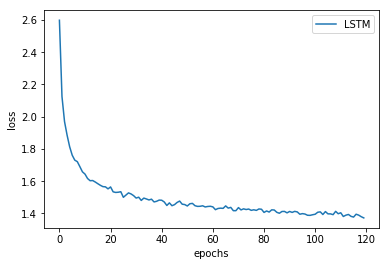

In [0]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(model.loss_history, label = 'LSTM')
plt.plot()
plt.legend(loc = "best")
plt.show()

### Sample of Generated Sequence

In [0]:
print('LSTM Sample Generation:\n\n')
print(model.generate(predicted_length = 5000))

LSTM Sample Generation:


What, I did wold, my good s event
Our kings

QUEEN ELIZABETH
But good moul we beg.

ISABELLA
Yes, in but we know what boy
My tenrery cast hackblate of mistress

DUKE OF YORK
Heth his word more.

MARIANA
Gensle what if Fir you mine pleasure, and then spiriting.

SLY

First
Great as thy gracious lament
Mnex. 
NORTHAPARO
Contation Hast undenheli, pray yourcelCAY
Where we tell outfully doth he I do undue Kate Confest.
So for the world to me, have my fort;
And he will jass. Most I have we live
The I same me at the errazenest forgeds forbas.
Should hast it pity worthy that singer mex should gla,
And, your horse on justice I'll comhound
In with forged adman,
Is not you discomf he
His one sole tham giveft.

MARCIUS
O swoman.
I.
Whom thou calmpnat be so legler, they became my needs
Ours

JULIET
Doth these marry, you innocence forstand
Commend me now, men by the lengm unwiltewn trumbet nihestly saln.

MAMIICHER,
That thet, I know, by thy mifficey, wears
So my son, hithe

### Loss distribution

In [0]:
mean_lstm_loss = np.mean(model.loss_history)
print('Average loss for LSTM network:\n', mean_lstm_loss)

final_lstm_loss = model.loss_history[-1]
print('\nFinal loss for LSTM network:\n', final_lstm_loss)


Average loss for LSTM network:
 1.4886059596776962

Final loss for LSTM network:
 1.3720582461357116
